# EDA

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


## Transactions Data Set

Here we will explore the transactions data set. We will look at the distribution of the data, the missing values, and the outliers.

In [3]:
df = pd.read_csv('data/HI-Small_Trans_adjusted.csv')

def rename_columns(df):
    new_cols = {}
    for col in df.columns:
        new_col = col.lower().replace(' ', '_')
        new_cols[col] = new_col
    return df.rename(columns=new_cols)


df = rename_columns(df)
# Rename the 'account' column to 'from_account'
df = df.rename(columns={'account': 'from_account'})

# Rename the 'account.1' column to 'to_account'
df = df.rename(columns={'account.1': 'to_account'})

df['timestamp'] = pd.to_datetime(df['timestamp'])
# Extract the hour from the timestamp
df['hour'] = df['timestamp'].dt.hour
# Extract the day of the week from the timestamp (Monday=0, Sunday=6)
df['day_of_week'] = df['timestamp'].dt.dayofweek
# Extract the month from the timestamp
df['month'] = df['timestamp'].dt.month
# Extract day of the month from the timestamp 
df['day_of_month'] = df['timestamp'].dt.day


In [4]:
df.head()

,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,hour,day_of_week,month,day_of_month
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,0,3,9,1
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,0,3,9,1
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,0,3,9,1
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,0,3,9,1
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,0,3,9,1


In [5]:
# group by day_of_month and get number of rows
df.groupby('day_of_month').count()['timestamp']

day_of_month
1     1114921
2      754449
3      207382
4      207430
5      482650
6      482089
7      482751
8      482773
9      160553
10        290
11        194
12         57
13          7
14          8
Name: timestamp, dtype: int64

In [4]:
# save the dataframe to a new csv file overwriting the old one
# df.to_csv('data/HI-Small_Trans_adjusted.csv', index=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4375554 entries, 0 to 4375553
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamp           object 
 1   from_bank           int64  
 2   from_account        object 
 3   to_bank             int64  
 4   to_account          object 
 5   amount_received     float64
 6   receiving_currency  object 
 7   amount_paid         float64
 8   payment_currency    object 
 9   payment_format      object 
 10  is_laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 367.2+ MB


In [6]:
df.describe()

,from_bank,to_bank,amount_received,amount_paid,is_laundering
count,4.375554e+06,4.375554e+06,4.375554e+06,4.375554e+06,4.375554e+06
mean,4.504443e+04,6.593507e+04,6.024675e+06,4.601136e+06,9.543934e-04
std,8.023166e+04,8.437782e+04,1.028182e+09,8.833349e+08,3.087852e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.210000e+02,4.403000e+03,1.791800e+02,1.804600e+02,0.000000e+00
50%,1.005700e+04,2.157500e+04,1.435670e+03,1.439415e+03,0.000000e+00
75%,2.831700e+04,1.223320e+05,1.277631e+04,1.272508e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


In [7]:
'''Checking for any null values'''

print('Null Values =',df.isnull().values.any())

Null Values = False


### Payment_format deep dive
In this section we will look at the payment_format column in which we discover interesting patterns

In [8]:
# Get the count and percentage of each payment format
counts = df['payment_format'].value_counts().to_frame()
counts['percentage_of_transaction'] = counts['payment_format'] / len(df) * 100
print(counts)


              payment_format  percentage_of_transaction
Cheque               1578228                  36.069215
Credit Card          1125878                  25.731096
ACH                   502115                  11.475461
Reinvestment          481056                  10.994174
Cash                  415462                   9.495072
Wire                  146948                   3.358386
Bitcoin               125867                   2.876596


In [9]:
# Calculate the average amount paid per transaction for each payment format, and sort the results in descending order

# Group the DataFrame by payment_format and calculate the mean payment amount for each group
avg_amount = df.groupby('payment_format')['amount_paid'].mean()

# Divide the mean payment amount by the number of transactions for each payment_format to get the average amount_paid per transaction
num_transactions = df['payment_format'].value_counts()
avg_amount_per_transaction = avg_amount / num_transactions

# Convert the resulting Series into a DataFrame and sort it by the average amount_paid per transaction in descending order
result_df = avg_amount_per_transaction.to_frame()

# rename column name to 'average_amount_paid'
result_df = result_df.rename(columns={0: 'average_amount_paid'})

# sort the values in descending order
result_df = result_df.sort_values(by='average_amount_paid', ascending=False)
result_df

,average_amount_paid
Wire,34.004149
ACH,21.282938
Cash,17.546826
Reinvestment,5.394401
Cheque,3.876954
Credit Card,0.077772
Bitcoin,0.000260


### Bank Deep Dive

In [10]:
# Get the count and percentage of transactions grouped by from_bank
from_counts = df.groupby('from_bank').size().sort_values(ascending=False).head(10)
from_pct = from_counts / len(df) * 100

# Get the count and percentage of transactions grouped by to_bank
to_counts = df.groupby('to_bank').size().sort_values(ascending=False).head(10)
to_pct = to_counts / len(df) * 100

# Combine the count and percentage results into a single DataFrame
result_df = pd.concat([from_counts, from_pct, to_counts, to_pct], axis=1, keys=['from_count', 'from_pct', 'to_count', 'to_pct'])

# Print the resulting DataFrame
print(result_df)

     from_count  from_pct  to_count    to_pct
70     383541.0  8.765541       NaN       NaN
10      70155.0  1.603340   36599.0  0.836443
12      68499.0  1.565493   36095.0  0.824924
1       53382.0  1.220006   25878.0  0.591422
15      45197.0  1.032943   33296.0  0.760955
220     45044.0  1.029447   26260.0  0.600153
20      35225.0  0.805041   19008.0  0.434414
3       33178.0  0.758258   22082.0  0.504668
7       26782.0  0.612082   19764.0  0.451691
211     26414.0  0.603672   17664.0  0.403697
28          NaN       NaN   18287.0  0.417936


### Bank Account Analyis

In [11]:
# Get the count of distinct 'from_account' and 'to_account' values
from_count = df['from_account'].nunique()
to_count = df['to_account'].nunique()

print("Distinct 'from_account' count:", from_count)
print("Distinct 'to_account' count:", to_count)


Distinct 'from_account' count: 495396
Distinct 'to_account' count: 420334


In [12]:
# Get the count and percentage of accounts that overlap between 'from_account' and 'to_account'
from_set = set(df['from_account'].unique())
to_set = set(df['to_account'].unique())
overlap_count = len(from_set.intersection(to_set))

total_count = len(from_set.union(to_set))

overlap_pct = overlap_count / total_count * 100

print("Number of accounts in both 'from_account' and 'to_account':", overlap_count)
print("Percentage of accounts in both 'from_account' and 'to_account': {:.2f}%".format(overlap_pct))


Number of accounts in both 'from_account' and 'to_account': 401516
Percentage of accounts in both 'from_account' and 'to_account': 78.08%


In [13]:
# Get the count and percentage of accounts that don't overlap between 'from_account' and 'to_account'
from_set = set(df['from_account'].unique())
to_set = set(df['to_account'].unique())
non_overlap_count = len(from_set.symmetric_difference(to_set))

total_count = len(from_set.union(to_set))

non_overlap_pct = non_overlap_count / total_count * 100

print("Number of accounts not in both 'from_account' and 'to_account':", non_overlap_count)
print("Percentage of accounts not in both 'from_account' and 'to_account': {:.2f}%".format(non_overlap_pct))


Number of accounts not in both 'from_account' and 'to_account': 112698
Percentage of accounts not in both 'from_account' and 'to_account': 21.92%


### Check multicolinearity between variables 

Check if we need to remove features based on the high colinearity.

<AxesSubplot:title={'center':'Correlation Matrix'}>

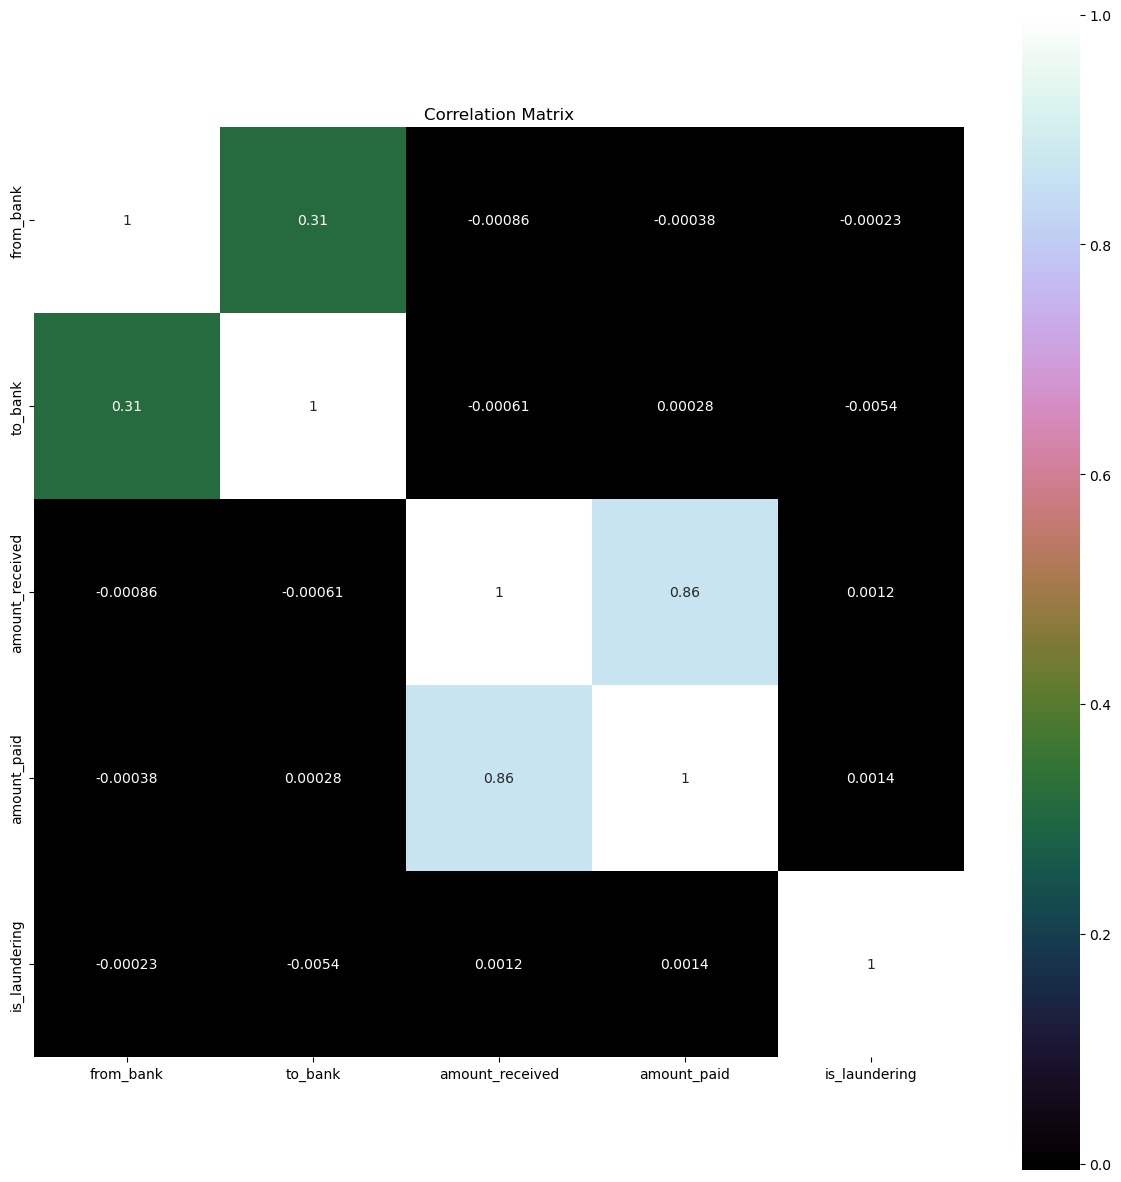

In [14]:

''' correlation matrix to check multicolinearity between variables '''

correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### Is_laudering = 1 Analysis

In [32]:
# get rows where is_laudering is 1
df_laundering = df[df['is_laundering'] == 1]

# Get the count and percentage of each payment format
counts = df_laundering['payment_format'].value_counts().to_frame()
counts['percentage_of_transaction'] = counts['payment_format'] / len(df_laundering) * 100
print(len(df_laundering) / len(df) * 100)
print(counts)

0.09543934322373807
             payment_format  percentage_of_transaction
ACH                    3583                  85.799808
Cheque                  275                   6.585249
Credit Card             178                   4.262452
Cash                     93                   2.227011
Bitcoin                  47                   1.125479


In [33]:
# get rows where is_laudering is 0
df_isNotlaundering = df[df['is_laundering'] == 0]

# Get the count and percentage of each payment format
counts = df_isNotlaundering['payment_format'].value_counts().to_frame()
counts['percentage_of_transaction'] = counts['payment_format'] / len(df_isNotlaundering) * 100
print(counts)

              payment_format  percentage_of_transaction
Cheque               1577953                  36.097382
Credit Card          1125700                  25.751605
ACH                   498532                  11.404459
Reinvestment          481056                  11.004676
Cash                  415369                   9.502015
Wire                  146948                   3.361594
Bitcoin               125820                   2.878269


### Timestemp Analysis
Here we perform a thorough analysis on the timestamp column. 

#### Hourly Analysis

In [7]:
import plotly.graph_objects as go

In [42]:
# Calculate the number of transactions per hour for each laundering status (0: legitimate, 1: laundering)
transactions_by_hour = df.groupby(['hour', 'is_laundering']).size().unstack()

# Calculate the percentage of transactions per hour within each laundering status
transactions_by_hour_pct = transactions_by_hour.div(transactions_by_hour.sum(axis=0), axis=1) * 100

# Create a Plotly bar chart to visualize the data
fig = go.Figure()

fig.add_trace(go.Bar(x=transactions_by_hour_pct.index, y=transactions_by_hour_pct[0], name='Legitimate'))
fig.add_trace(go.Bar(x=transactions_by_hour_pct.index, y=transactions_by_hour_pct[1], name='Laundering'))

fig.update_layout(barmode='group', title='Percentage of Transactions per Hour by Laundering Status',
                  xaxis_title='Hour of the Day', yaxis_title='Percentage of Transactions within Each Group')

fig.show()

##### Chi-Square Test

Based on this test, there is a significant relationship between the hour of the day and the likelihood of a transaction being laundering. This information can be used to create new features for your classification model, such as a binary feature indicating whether a transaction occurred during hours with a higher likelihood of laundering.

In [50]:
# Calculate the number of transactions per hour for each laundering status (0: legitimate, 1: laundering)
transactions_by_hour = df.groupby(['hour', 'is_laundering']).size().unstack().fillna(0)

# Perform the Chi-square test for independence
chi2, p_value, _, _ = chi2_contingency(transactions_by_hour)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")


Chi-square statistic: 772.0075395568896
P-value: 2.859717942803346e-148


#### Day Analysis

In [44]:
# Calculate the number of transactions per day of the week for each laundering status (0: legitimate, 1: laundering)
transactions_by_day = df.groupby(['day_of_week', 'is_laundering']).size().unstack()

# Calculate the percentage of transactions per day of the week within each laundering status
transactions_by_day_pct = transactions_by_day.div(transactions_by_day.sum(axis=0), axis=1) * 100

# Create a Plotly bar chart to visualize the data
fig = go.Figure()

fig.add_trace(go.Bar(x=transactions_by_day_pct.index, y=transactions_by_day_pct[0], name='Legitimate'))
fig.add_trace(go.Bar(x=transactions_by_day_pct.index, y=transactions_by_day_pct[1], name='Laundering'))

fig.update_layout(barmode='group', title='Percentage of Transactions per Day of the Week by Laundering Status',
                  xaxis_title='Day of the Week (Monday=0, Sunday=6)', yaxis_title='Percentage of Transactions within Each Group')

fig.show()

##### Chi-Square Test

In [51]:
# Calculate the number of transactions per day of the week for each laundering status (0: legitimate, 1: laundering)
transactions_by_day = df.groupby(['day_of_week', 'is_laundering']).size().unstack().fillna(0)

# Perform the Chi-square test for independence
chi2, p_value, _, _ = chi2_contingency(transactions_by_day)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic: 1514.577696046295
P-value: 0.0


### Day of the month Analysis

In [8]:
# Calculate the number of transactions per day of the month for each laundering status (0: legitimate, 1: laundering)
transactions_by_day = df.groupby(['day_of_month', 'is_laundering']).size().unstack()

# Calculate the percentage of transactions per day of the month within each laundering status
transactions_by_day_pct = transactions_by_day.div(transactions_by_day.sum(axis=0), axis=1) * 100

# Create a Plotly bar chart to visualize the data
fig = go.Figure()

fig.add_trace(go.Bar(x=transactions_by_day_pct.index, y=transactions_by_day_pct[0], name='Legitimate'))
fig.add_trace(go.Bar(x=transactions_by_day_pct.index, y=transactions_by_day_pct[1], name='Laundering'))

fig.update_layout(barmode='group', title='Percentage of Transactions per Day of the Month by Laundering Status',
                  xaxis_title='Day of the Month', yaxis_title='Percentage of Transactions within Each Group')

fig.show()


#### Chi-square Test

In [9]:
# Calculate the number of transactions per day of the week for each laundering status (0: legitimate, 1: laundering)
transactions_by_day = df.groupby(['day_of_month', 'is_laundering']).size().unstack().fillna(0)

# Perform the Chi-square test for independence
chi2, p_value, _, _ = chi2_contingency(transactions_by_day)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic: 201884.5056557713
P-value: 0.0


### Feature Engineering

#### Difference between the percentages for day_of_week, day_of_month, hour
Here, it's added 3 extra columns to the dataset, which are the difference between the percentage of transactions that are laundering and the percentage of transactions that are not laundering for each day of the week, day of the month, and hour of the day. This information can be used to create new features for your classification model, such as a binary feature indicating whether a transaction occurred during hours with a higher likelihood of laundering.

In [21]:
def calculate_difference(df, time_unit):
    # Calculate the number of transactions per time unit for each laundering status (0: legitimate, 1: laundering)
    transactions_by_time_unit = df.groupby([time_unit, 'is_laundering']).size().unstack()

    # Calculate the percentage of transactions per time unit within each laundering status
    transactions_by_time_unit_pct = transactions_by_time_unit.div(transactions_by_time_unit.sum(axis=0), axis=1) * 100

    # Calculate the difference between the percentages of laundering and legitimate transactions
    transactions_by_time_unit_pct['difference_' + time_unit] = transactions_by_time_unit_pct[1] - transactions_by_time_unit_pct[0]

    # Reset the index of the DataFrame so that time_unit is a column instead of an index
    transactions_by_time_unit_pct.reset_index(inplace=True)

    # Merge the original DataFrame with the new DataFrame on the time_unit column
    df = df.merge(transactions_by_time_unit_pct[[time_unit, 'difference_' + time_unit]], on=time_unit)
    
    return df

# Apply the function to 'hour', 'day_of_week' and 'day_of_month'
df = calculate_difference(df, 'hour')
df = calculate_difference(df, 'day_of_week')
df = calculate_difference(df, 'day_of_month')


In [22]:
# select the rows which day_of_week is 0 (Monday)
df[df['day_of_week'] == 0]

,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,hour,day_of_week,month,day_of_month,difference_hour,difference_day_of_week,difference_day_of_month
3410088,2022-09-05 00:58:00,2843,800A4B110,513,8005A1B80,17777.45,US Dollar,17777.45,US Dollar,ACH,1,0,0,9,5,-10.168012,1.157897,0.248369
3410089,2022-09-05 00:29:00,1522,80055F090,1522,80055F090,19533.96,US Dollar,16670.28,Euro,ACH,0,0,0,9,5,-10.168012,1.157897,0.248369
3410090,2022-09-05 00:29:00,1522,80055F090,1665,80054CAB0,19533.96,US Dollar,19533.96,US Dollar,ACH,1,0,0,9,5,-10.168012,1.157897,0.248369
3410091,2022-09-05 00:27:00,18196,8035CD610,18196,8035CD610,779777.58,Rupee,71110.48,Yuan,ACH,0,0,0,9,5,-10.168012,1.157897,0.248369
3410092,2022-09-05 00:27:00,18196,8035CD610,16,8050B7870,779777.58,Rupee,779777.58,Rupee,ACH,1,0,0,9,5,-10.168012,1.157897,0.248369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892790,2022-09-12 12:28:00,14804,806698470,14804,806698470,68984.01,Yuan,10299.81,US Dollar,ACH,0,12,0,9,12,2.875409,1.157897,0.909527
3892791,2022-09-12 12:28:00,14804,806698470,18107,807E2E610,68984.01,Yuan,68984.01,Yuan,ACH,1,12,0,9,12,2.875409,1.157897,0.909527
3892792,2022-09-12 12:05:00,20,800195070,23,8001B8810,13829.37,Euro,13829.37,Euro,ACH,1,12,0,9,12,2.875409,1.157897,0.909527
3892793,2022-09-12 12:28:00,24,803D94320,24,803D94320,13561.88,US Dollar,1429422.01,Yen,ACH,0,12,0,9,12,2.875409,1.157897,0.909527


In [23]:
# save df as csv
df.to_csv('data/HI-Small_Trans_adjusted.csv', index=False)

df = pd.read_csv('data/HI-Small_Trans_adjusted.csv')